In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ruptures

In [ ]:
!pip install pyts

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of /content/drive/MyDrive/dataset_yolo_final: ['nifty50_labels.csv', 'dataset_yolo_final', 'gaf_images', 'crossvit_best_model.pth', 'confusion_matrix_recession_2008_tta.png', 'confusion_matrix_recession_covid_tta.png', 'processed_data', 'crossvit_tta_adapted_model.pth', 'crossvit_tta_adapted_model_low_conf.pth']
Mapping - Symbol_Period: ADANIPORTS_1-90, Label: No Pattern Detected
Mapping - Symbol_Period: ADANIPORTS_91-180, Label: No Pattern Detected
Mapping - Symbol_Period: ADANIPORTS_181-270, Label: No Pattern Detected
Mapping - Symbol_Period: ADANIPORTS_271-360, Label: Triple Bottom Reversal
Mapping - Symbol_Period: ADANIPORTS_361-450, Label: Double Top
Class distribution before cleaning null labels: Counter({None: 920, 'Triple Bottom Reversal': 408, 'Ascending Triangle': 247, 'Symmetrical Triangle': 174, 'Head and Shoulders': 138, 'Descending Tria

<ipython-input-4-13b37055adbb>:261: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  synthetic = np.random.multivariate_normal(mean_vector, cov_matrix, samples_per_cluster)
<ipython-input-4-13b37055adbb>:261: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  synthetic = np.random.multivariate_normal(mean_vector, cov_matrix, samples_per_cluster)
<ipython-input-4-13b37055adbb>:261: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  synthetic = np.random.multivariate_normal(mean_vector, cov_matrix, samples_per_cluster)


Saved stable_covid.csv to /content/drive/MyDrive/dataset_yolo_final/processed_data/stable_covid.csv
Saved other_periods.csv to /content/drive/MyDrive/dataset_yolo_final/processed_data/other_periods.csv
Saved train_data.csv to /content/drive/MyDrive/dataset_yolo_final/processed_data/train_data.csv
Saved ood_data.csv to /content/drive/MyDrive/dataset_yolo_final/processed_data/ood_data.csv
Time series length for EICHERMOT_1711-1800: 360 (should be 360)
GAF Summation for EICHERMOT_1711-1800 - Min: 0, Max: 255, Mean: 35.5153659119898
GAF Difference for EICHERMOT_1711-1800 - Min: 0, Max: 255, Mean: 127.00001992984694
Time series length for ADANIPORTS_811-900_synthetic_58: 360 (should be 360)
GAF Summation for ADANIPORTS_811-900_synthetic_58 - Min: 0, Max: 255, Mean: 25.477459343112244
GAF Difference for ADANIPORTS_811-900_synthetic_58 - Min: 0, Max: 255, Mean: 127.00001992984694
Time series length for SUNPHARMA_3511-3600: 360 (should be 360)
GAF Summation for SUNPHARMA_3511-3600 - Min: 0, Ma

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/100, Train Loss: 1.3632, Val Loss: 1.5392, Val Accuracy: 0.2431, F1: 0.2090
Saved best model with F1: 0.2090, Best Val Accuracy: 0.2431
Epoch 2/100, Train Loss: 1.2411, Val Loss: 1.1067, Val Accuracy: 0.3125, F1: 0.2247
Saved best model with F1: 0.2247, Best Val Accuracy: 0.3125
Epoch 3/100, Train Loss: 1.1104, Val Loss: 1.0899, Val Accuracy: 0.3750, F1: 0.2770
Saved best model with F1: 0.2770, Best Val Accuracy: 0.3750
Epoch 4/100, Train Loss: 1.2522, Val Loss: 1.2621, Val Accuracy: 0.2917, F1: 0.2178
Epoch 5/100, Train Loss: 1.3787, Val Loss: 1.5030, Val Accuracy: 0.2292, F1: 0.1089
Epoch 6/100, Train Loss: 1.3472, Val Loss: 1.2115, Val Accuracy: 0.2569, F1: 0.1380
Epoch 7/100, Train Loss: 1.2979, Val Loss: 1.2019, Val Accuracy: 0.2361, F1: 0.0975
Epoch 8/100, Train Loss: 1.2389, Val Loss: 1.3040, Val Accuracy: 0.1667, F1: 0.0821
Epoch 9/100, Train Loss: 1.2567, Val Loss: 1.2084, Val Accuracy: 0.2431, F1: 0.1525
Epoch 10/100, Train Loss: 1.1857, Val Loss: 1.1509, Val Accuracy

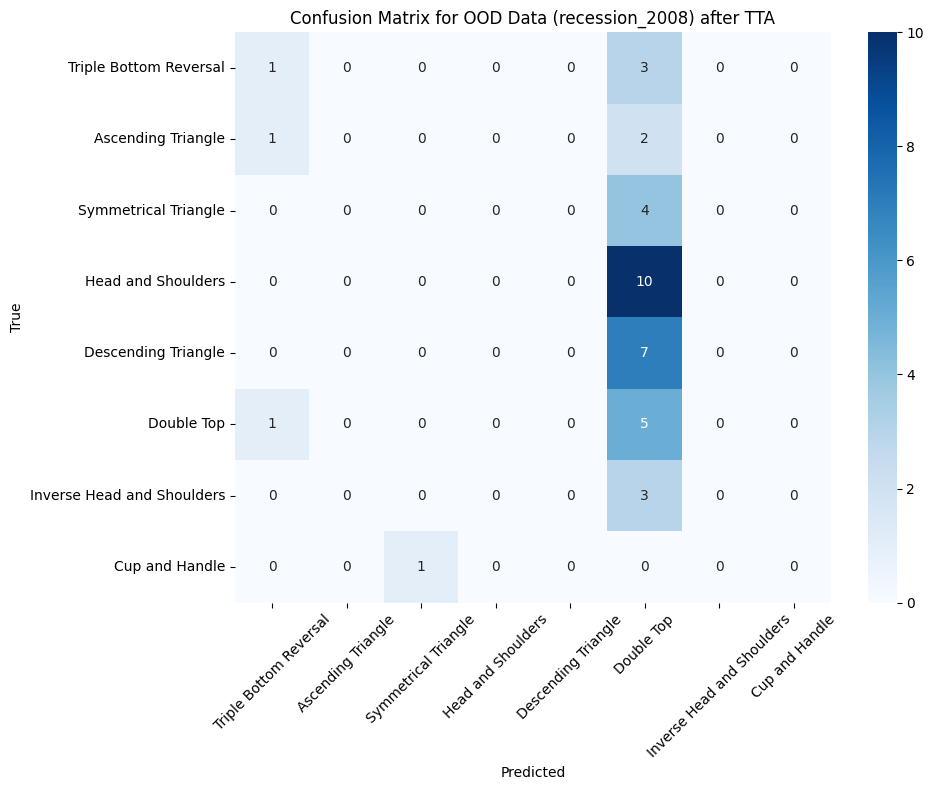

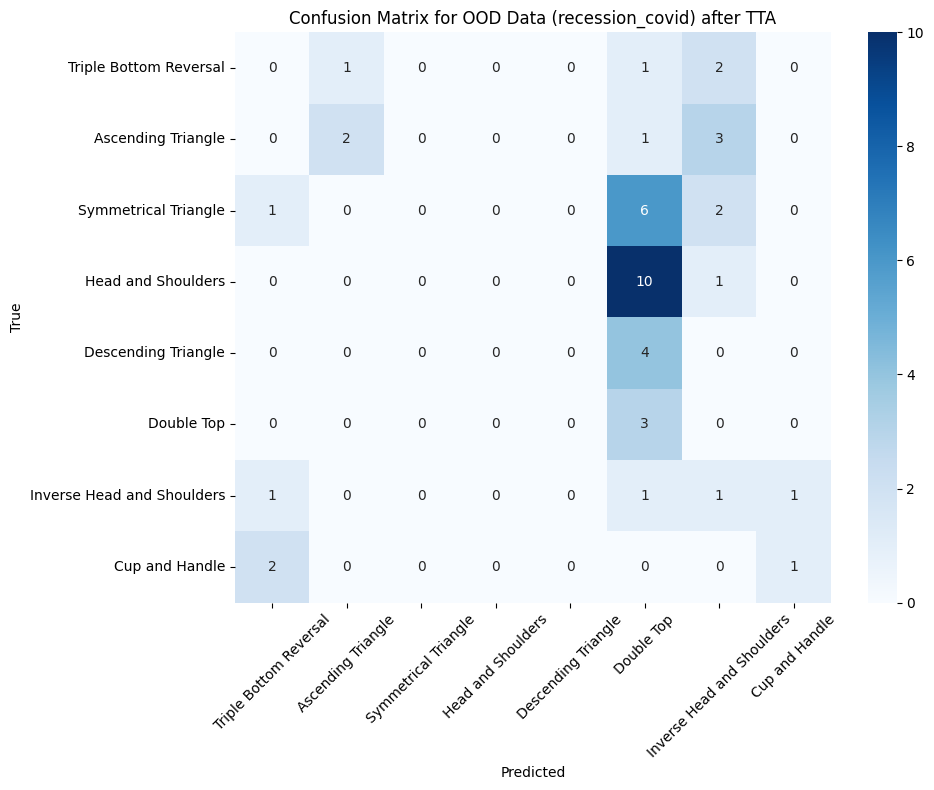

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import timm
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf
from pyts.image import GramianAngularField
import random
from collections import Counter

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
base_path = '/content/drive/MyDrive/dataset_yolo_final'
labels_csv_path = '/content/drive/MyDrive/dataset_yolo_final/nifty50_labels.csv'
ohlc_csv_path = '/content/drive/MyDrive/dataset_yolo/NIFTY50_all.csv'
processed_data_dir = f'{base_path}/processed_data'  # New directory for saving processed data
os.makedirs(processed_data_dir, exist_ok=True)

# Create directories for GAF images
images_base_dir = f'{base_path}/gaf_images'
os.makedirs(images_base_dir, exist_ok=True)

# Debug: Confirm file existence
print("Contents of /content/drive/MyDrive/dataset_yolo_final:", os.listdir('/content/drive/MyDrive/dataset_yolo_final'))
if not os.path.exists(labels_csv_path):
    raise FileNotFoundError(f"File not found: {labels_csv_path}")
if not os.path.exists(ohlc_csv_path):
    raise FileNotFoundError(f"File not found: {ohlc_csv_path}")

# --- Custom Dataset Class for GAF Images ---

class GAFDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Load the datasets
pattern_df = pd.read_csv(labels_csv_path)
ohlc_df = pd.read_csv(ohlc_csv_path)
ohlc_df['Date'] = pd.to_datetime(ohlc_df['Date'])

#  Create 90-day periods dynamically from NIFTY50_all.csv with specified features
def create_90_day_periods_with_features(ohlc_df):
    periods = []
    symbols = ohlc_df['Symbol'].unique()

    for symbol in symbols:
        symbol_data = ohlc_df[ohlc_df['Symbol'] == symbol].sort_values('Date')
        dates = symbol_data['Date'].values
        num_days = len(dates)

        for start_idx in range(0, num_days, 90):
            end_idx = min(start_idx + 90, num_days)
            if end_idx - start_idx < 90:
                break
            period_data = symbol_data.iloc[start_idx:end_idx]

            start_date = dates[start_idx]
            end_date = dates[end_idx - 1]
            period = f"{start_idx + 1}-{end_idx}"
            symbol_period = f"{symbol}_{period}"

            initial_open = period_data.iloc[0]['Open']
            close = period_data.iloc[-1]['Close']
            high = period_data['High'].max()
            low = period_data['Low'].min()
            total_volume = period_data['Volume'].sum()

            prev_data = symbol_data[symbol_data['Date'] < start_date]
            prev_close = prev_data.iloc[-1]['Close'] if not prev_data.empty else initial_open

            periods.append({
                'Symbol': symbol,
                'Period': period,
                'Symbol_Period': symbol_period,
                'Start_Date': start_date,
                'End_Date': end_date,
                'Initial_Open': initial_open,
                'Close': close,
                'High': high,
                'Low': low,
                'Prev_Close': prev_close,
                'Volume': total_volume
            })

    return pd.DataFrame(periods)

# Create the periods DataFrame with features
period_df = create_90_day_periods_with_features(ohlc_df)
valid_periods = set(period_df['Symbol_Period'])

# Filter pattern_df to include only periods present in the dynamically created periods
pattern_df = pattern_df[pattern_df['Company_Period'].isin(valid_periods)]

# Define class mapping
class_to_id = {
    'Triple Bottom Reversal': 0,
    'Ascending Triangle': 1,
    'Symmetrical Triangle': 2,
    'Head and Shoulders': 3,
    'Descending Triangle': 4,
    'Double Top': 5,
    'Inverse Head and Shoulders': 6,
    'Cup and Handle': 7
}
id_to_class = {v: k for k, v in class_to_id.items()}

# Labels to map to null
labels_to_null = ['No Pattern Detected', 'Falling Wedge', 'Double Bottom', 'Flag and Pole']

# Helper function to extract features for a period
def extract_features(symbol_period):
    period_row = period_df[period_df['Symbol_Period'] == symbol_period].iloc[0]
    features = [
        period_row['Initial_Open'],
        period_row['Close'],
        period_row['High'],
        period_row['Low'],
        period_row['Prev_Close'],
        period_row['Volume']
    ]
    return np.array(features)

# Helper function to extract the full OHLC time series for GAF generation
def extract_time_series(symbol_period, ohlc_df):
    symbol, period = symbol_period.split('_', 1)
    if '_synthetic_' in symbol_period or '_duplicate_' in symbol_period:
        base_symbol_period = symbol_period.split('_synthetic_')[0].split('_duplicate_')[0]
    else:
        base_symbol_period = symbol_period
    period_row = period_df[period_df['Symbol_Period'] == base_symbol_period].iloc[0]
    start_date = period_row['Start_Date']
    end_date = period_row['End_Date']
    time_series = ohlc_df[
        (ohlc_df['Symbol'] == symbol) &
        (ohlc_df['Date'] >= start_date) &
        (ohlc_df['Date'] <= end_date)
    ][['Open', 'High', 'Low', 'Close']].values
    fixed_length = 90
    num_days = time_series.shape[0]
    if num_days < fixed_length:
        padding = ((0, fixed_length - num_days), (0, 0))
        time_series = np.pad(time_series, padding, mode='edge')
    elif num_days > fixed_length:
        time_series = time_series[:fixed_length]
    time_series = time_series.flatten()
    print(f"Time series length for {symbol_period}: {len(time_series)} (should be {fixed_length * 4})")
    return time_series

# Collect data with features and labels
data = []
for _, row in period_df.iterrows():
    symbol_period = row['Symbol_Period']
    if symbol_period in pattern_df['Company_Period'].values:
        try:
            features = extract_features(symbol_period)
            pattern = pattern_df[pattern_df['Company_Period'] == symbol_period]['Label'].iloc[0]
            if len(data) < 5:
                print(f"Mapping - Symbol_Period: {symbol_period}, Label: {pattern}")
            if pattern in labels_to_null:
                pattern = None
            data.append((symbol_period, features, pattern, row['Start_Date'], row['End_Date']))
        except IndexError:
            print(f"Skipping {symbol_period}: No data available.")

# Print class distribution before cleaning
patterns_before = [pattern for _, _, pattern, _, _ in data]
print("Class distribution before cleaning null labels:", Counter(patterns_before))

# Remove rows with null labels
data = [(sp, feats, p, start, end) for sp, feats, p, start, end in data if p is not None]

#  Print class distribution after cleaning
patterns_after = [pattern for _, _, pattern, _, _ in data]
print("Class distribution after cleaning null labels:", Counter(patterns_after))

# Save the mapping as a CSV
data_df = pd.DataFrame({
    'Symbol_Period': [x[0] for x in data],
    'Initial_Open': [x[1][0] for x in data],
    'Close': [x[1][1] for x in data],
    'High': [x[1][2] for x in data],
    'Low': [x[1][3] for x in data],
    'Prev_Close': [x[1][4] for x in data],
    'Volume': [x[1][5] for x in data],
    'Label': [x[2] for x in data],
    'Start_Date': [x[3] for x in data],
    'End_Date': [x[4] for x in data]
})
data_df.to_csv(os.path.join(processed_data_dir, 'mapped_data.csv'), index=False)
print(f"Saved mapping to {processed_data_dir}/mapped_data.csv")

# OHIT Oversampling Function for features
def ohit_oversample_features(data, target_samples, min_samples=2):
    if len(data) < min_samples:
        print(f"Enforcing minimum of {min_samples} samples for class with {len(data)} samples...")
        while len(data) < min_samples:
            data.append((f"{data[-1][0]}_duplicate_{len(data)}", data[-1][1], data[-1][2], data[-1][3], data[-1][4]))

    if len(data) > target_samples:
        print(f"Downsampling {len(data)} to {target_samples} samples...")
        indices = np.random.choice(len(data), target_samples, replace=False)
        return [data[i] for i in indices]

    if len(data) < target_samples:
        X = np.array([feats for _, feats, _, _, _ in data])
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        clustering = DBSCAN(eps=0.5, min_samples=3, metric='euclidean').fit(X_scaled)
        labels = clustering.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters == 0:
            labels = np.zeros(len(X), dtype=int)
            n_clusters = 1

        synthetic_samples = []
        samples_per_cluster = (target_samples - len(data)) // max(n_clusters, 1)

        for cluster_id in range(n_clusters):
            cluster_indices = np.where(labels == cluster_id)[0]
            if len(cluster_indices) < 2:
                continue
            cluster_data = X[cluster_indices]

            cov_estimator = LedoitWolf()
            cov_matrix = cov_estimator.fit(cluster_data).covariance_
            mean_vector = np.mean(cluster_data, axis=0)

            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            eigenvalues = np.maximum(eigenvalues, 1e-6)
            cov_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

            synthetic = np.random.multivariate_normal(mean_vector, cov_matrix, samples_per_cluster)
            synthetic = scaler.inverse_transform(synthetic)
            for i, synth_sample in enumerate(synthetic):
                original_symbol_period = data[cluster_indices[0]][0]
                original_pattern = data[cluster_indices[0]][2]
                original_start_date = data[cluster_indices[0]][3]
                original_end_date = data[cluster_indices[0]][4]
                synth_symbol_period = f"{original_symbol_period}_synthetic_{i}"
                synthetic_samples.append((synth_symbol_period, synth_sample, original_pattern, original_start_date, original_end_date))
                if i < 2:
                    print(f"Synthetic Sample - Symbol_Period: {synth_symbol_period}, Label: {original_pattern}, Features: {synth_sample}")

        all_samples = data + synthetic_samples
        all_samples = all_samples[:target_samples]
        return all_samples

    return data

# Oversample data per class
target_per_class = 100
class_samples = {}
for symbol_period, feats, pattern, start_date, end_date in data:
    if pattern not in class_samples:
        class_samples[pattern] = []
    class_samples[pattern].append((symbol_period, feats, pattern, start_date, end_date))

balanced_data = []
for pattern, samples in class_samples.items():
    balanced_samples = ohit_oversample_features(samples, target_per_class, min_samples=2)
    balanced_data.extend(balanced_samples)

# Print class distribution after oversampling
patterns_after_oversampling = [pattern for _, _, pattern, _, _ in balanced_data]
print("Class distribution after oversampling:", Counter(patterns_after_oversampling))

#  Check the range of features in balanced_data
all_features = np.array([feats for _, feats, _, _, _ in balanced_data])
print(f"Feature stats after oversampling - Min: {all_features.min(axis=0)}, Max: {all_features.max(axis=0)}, Mean: {all_features.mean(axis=0)}")

# Categorize periods into recession/stable/other and save each category
recession_2008 = []
stable_2008 = []
recession_covid = []
stable_covid = []
other_periods = []
train_data = []
ood_data = []

recession_2008_start = pd.to_datetime('2007-11-27')
recession_2008_end = pd.to_datetime('2008-09-02')
stable_2008_start = pd.to_datetime('2003-01-01')
stable_2008_end = pd.to_datetime('2007-06-30')
recession_covid_start = pd.to_datetime('2019-10-10')
recession_covid_end = pd.to_datetime('2020-05-14')
stable_covid_start = pd.to_datetime('2016-01-01')
stable_covid_end = pd.to_datetime('2019-06-30')

for symbol_period, feats, pattern, start_date, end_date in balanced_data:
    period_type = 'other'
    if (start_date <= recession_2008_end) and (end_date >= recession_2008_start):
        period_type = 'recession_2008'
        recession_2008.append((symbol_period, feats, pattern, start_date, end_date))
    elif (start_date <= stable_2008_end) and (end_date >= stable_2008_start):
        period_type = 'stable_2008'
        stable_2008.append((symbol_period, feats, pattern, start_date, end_date))
    elif (start_date <= recession_covid_end) and (end_date >= recession_covid_start):
        period_type = 'recession_covid'
        recession_covid.append((symbol_period, feats, pattern, start_date, end_date))
    elif (start_date <= stable_covid_end) and (end_date >= stable_covid_start):
        period_type = 'stable_covid'
        stable_covid.append((symbol_period, feats, pattern, start_date, end_date))
    else:
        period_type = 'other'
        other_periods.append((symbol_period, feats, pattern, start_date, end_date))

    if period_type in ['recession_2008', 'recession_covid']:
        ood_data.append((symbol_period, feats, pattern, start_date, end_date))
    else:
        train_data.append((symbol_period, feats, pattern, start_date, end_date))

# Shuffle train_data and ood_data
random.shuffle(train_data)
random.shuffle(ood_data)

#  Print sizes of each category
print(f"recession_2008 size: {len(recession_2008)}")
print(f"stable_2008 size: {len(stable_2008)}")
print(f"recession_covid size: {len(recession_covid)}")
print(f"stable_covid size: {len(stable_covid)}")
print(f"other_periods size: {len(other_periods)}")
print(f"Training data size: {len(train_data)}")
print(f"OOD data size: {len(ood_data)}")

# Save each category as a CSV
def save_periods_to_csv(periods, filename):
    df = pd.DataFrame({
        'Symbol_Period': [x[0] for x in periods],
        'Initial_Open': [x[1][0] for x in periods],
        'Close': [x[1][1] for x in periods],
        'High': [x[1][2] for x in periods],
        'Low': [x[1][3] for x in periods],
        'Prev_Close': [x[1][4] for x in periods],
        'Volume': [x[1][5] for x in periods],
        'Label': [x[2] for x in periods],
        'Start_Date': [x[3] for x in periods],
        'End_Date': [x[4] for x in periods]
    })
    df.to_csv(os.path.join(processed_data_dir, filename), index=False)
    print(f"Saved {filename} to {processed_data_dir}/{filename}")

save_periods_to_csv(recession_2008, 'recession_2008.csv')
save_periods_to_csv(stable_2008, 'stable_2008.csv')
save_periods_to_csv(recession_covid, 'recession_covid.csv')
save_periods_to_csv(stable_covid, 'stable_covid.csv')
save_periods_to_csv(other_periods, 'other_periods.csv')
save_periods_to_csv(train_data, 'train_data.csv')
save_periods_to_csv(ood_data, 'ood_data.csv')

# Generate GAF images for each period
gaf_summation = GramianAngularField(image_size=224, method='summation')
gaf_difference = GramianAngularField(image_size=224, method='difference')

def generate_gaf_image(symbol_period, ohlc_df, output_dir):
    time_series = extract_time_series(symbol_period, ohlc_df)
    time_series = time_series.reshape(1, -1)
    gaf_image_sum = gaf_summation.fit_transform(time_series)[0]
    gaf_image_sum = ((gaf_image_sum - gaf_image_sum.min()) / (gaf_image_sum.max() - gaf_image_sum.min()) * 255).astype(np.uint8)
    print(f"GAF Summation for {symbol_period} - Min: {gaf_image_sum.min()}, Max: {gaf_image_sum.max()}, Mean: {gaf_image_sum.mean()}")
    gaf_image_diff = gaf_difference.fit_transform(time_series)[0]
    gaf_image_diff = ((gaf_image_diff - gaf_image_diff.min()) / (gaf_image_diff.max() - gaf_image_diff.min()) * 255).astype(np.uint8)
    print(f"GAF Difference for {symbol_period} - Min: {gaf_image_diff.min()}, Max: {gaf_image_diff.max()}, Mean: {gaf_image_diff.mean()}")
    rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)
    rgb_image[:, :, 0] = gaf_image_sum  # R channel: summation
    rgb_image[:, :, 1] = gaf_image_diff  # G channel: difference
    rgb_image[:, :, 2] = 0  # B channel: set to 0
    img = Image.fromarray(rgb_image)
    img_name = symbol_period.replace('-', '_to_') + '_png.png'
    img_path = os.path.join(output_dir, img_name)
    img.save(img_path)
    return img_path

# Create subdirectories for train and OOD data
train_images_dir = os.path.join(images_base_dir, 'train')
ood_images_dir = os.path.join(images_base_dir, 'ood')
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(ood_images_dir, exist_ok=True)

# Generate GAF images for training data
train_image_paths = []
train_labels = []
for symbol_period, _, pattern, _, _ in train_data:
    img_path = generate_gaf_image(symbol_period, ohlc_df, train_images_dir)
    train_image_paths.append(img_path)
    train_labels.append(class_to_id[pattern])

# Generate GAF images for OOD data
ood_image_paths = []
ood_labels = []
for symbol_period, _, pattern, _, _ in ood_data:
    img_path = generate_gaf_image(symbol_period, ohlc_df, ood_images_dir)
    ood_image_paths.append(img_path)
    ood_labels.append(class_to_id[pattern])

# Check the RGB channels of a sample image
sample_img_path = train_image_paths[0]
sample_img = np.array(Image.open(sample_img_path))
print(f"Sample Image RGB Check for {sample_img_path}:")
print(f"R channel (Summation) mean: {sample_img[:, :, 0].mean()}")
print(f"G channel (Difference) mean: {sample_img[:, :, 1].mean()}")
print(f"B channel mean: {sample_img[:, :, 2].mean()} (should be 0)")

#  Print class distribution of train_labels and ood_labels
train_labels_dist = Counter([id_to_class[label] for label in train_labels])
ood_labels_dist = Counter([id_to_class[label] for label in ood_labels])
print("Training labels distribution:", train_labels_dist)
print("OOD labels distribution:", ood_labels_dist)

#  Print sample image-label pairs
print("Sample training image-label pairs:")
for img_path, label in zip(train_image_paths[:5], train_labels[:5]):
    print(f"Image: {img_path}, Label: {id_to_class[label]} ({label})")
print("Sample OOD image-label pairs:")
for img_path, label in zip(ood_image_paths[:5], ood_labels[:5]):
    print(f"Image: {img_path}, Label: {id_to_class[label]} ({label})")



transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Split training data into train and validation sets (80-20 split)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Create datasets
train_dataset = GAFDataset(train_paths, train_labels, transform=transform)
val_dataset = GAFDataset(val_paths, val_labels, transform=transform)
ood_dataset = GAFDataset(ood_image_paths, ood_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
ood_loader = DataLoader(ood_dataset, batch_size=8, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('crossvit_15_240', pretrained=True, num_classes=len(class_to_id)).to(device)
model.train()

# --- Define Focal Loss ---

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Training Loop with Focal Loss and Emphasis on Validation Accuracy ---

criterion = FocalLoss(alpha=1.0, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

num_epochs = 100
best_f1 = 0
best_val_accuracy = 0
patience = 20
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_preds = []
    val_true = []
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_true, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='weighted', zero_division=0)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_val_accuracy = val_accuracy
        early_stop_counter = 0
        torch.save(model.state_dict(), f'{base_path}/crossvit_best_model.pth')
        print(f"Saved best model with F1: {best_f1:.4f}, Best Val Accuracy: {best_val_accuracy:.4f}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

# Load the best model
model.load_state_dict(torch.load(f'{base_path}/crossvit_best_model.pth'))
model.eval()

# --- Final Validation Evaluation ---

print("\n--- Final Validation Evaluation ---")
val_preds = []
val_true = []
val_loss = 0.0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

val_loss /= len(val_loader)
final_val_accuracy = accuracy_score(val_true, val_preds)
precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='weighted', zero_division=0)
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Precision: {precision:.4f}")
print(f"Final Validation Recall: {recall:.4f}")
print(f"Final Validation F1: {f1:.4f}")

# --- Test-Time Adaptation (TTA) on OOD Data ---

def test_time_adaptation(model, loader, momentum=0.1):
    model.eval()
    for images, _ in loader:
        images = images.to(device)
        with torch.no_grad():
            _ = model(images)
        for module in model.modules():
            if isinstance(module, torch.nn.BatchNorm2d):
                batch_mean = torch.mean(images, dim=[0, 2, 3])
                batch_var = torch.var(images, dim=[0, 2, 3], unbiased=False)
                module.running_mean = (1 - momentum) * module.running_mean + momentum * batch_mean
                module.running_var = (1 - momentum) * module.running_var + momentum * batch_var
    return model

# Apply TTA
model = test_time_adaptation(model, ood_loader, momentum=0.1)

# Split OOD data into recession_2008 and recession_covid for separate evaluation
recession_2008_paths = []
recession_2008_labels = []
recession_covid_paths = []
recession_covid_labels = []

for img_path, label, (_, _, _, start_date, end_date) in zip(ood_image_paths, ood_labels, ood_data):
    if (start_date <= recession_2008_end) and (end_date >= recession_2008_start):
        recession_2008_paths.append(img_path)
        recession_2008_labels.append(label)
    elif (start_date <= recession_covid_end) and (end_date >= recession_covid_start):
        recession_covid_paths.append(img_path)
        recession_covid_labels.append(label)

recession_2008_dataset = GAFDataset(recession_2008_paths, recession_2008_labels, transform=transform)
recession_covid_dataset = GAFDataset(recession_covid_paths, recession_covid_labels, transform=transform)

recession_2008_loader = DataLoader(recession_2008_dataset, batch_size=8, shuffle=False)
recession_covid_loader = DataLoader(recession_covid_dataset, batch_size=8, shuffle=False)

# Evaluate on recession_2008
recession_2008_preds = []
recession_2008_true = []
with torch.no_grad():
    for images, labels in recession_2008_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        recession_2008_preds.extend(preds.cpu().numpy())
        recession_2008_true.extend(labels.cpu().numpy())

recession_2008_accuracy = accuracy_score(recession_2008_true, recession_2008_preds)
precision, recall, f1, _ = precision_recall_fscore_support(recession_2008_true, recession_2008_preds, average='weighted', zero_division=0)
print("\n--- OOD Evaluation Results (recession_2008) after TTA ---")
print(f"OOD Accuracy: {recession_2008_accuracy:.4f}")
print(f"OOD Precision: {precision:.4f}")
print(f"OOD Recall: {recall:.4f}")
print(f"OOD F1: {f1:.4f}")

# Compute and plot confusion matrix for recession_2008
cm_2008 = confusion_matrix(recession_2008_true, recession_2008_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_2008, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_to_id.keys()), yticklabels=list(class_to_id.keys()))
plt.title('Confusion Matrix for OOD Data (recession_2008) after TTA')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{base_path}/confusion_matrix_recession_2008_tta.png')

# Evaluate on recession_covid
recession_covid_preds = []
recession_covid_true = []
with torch.no_grad():
    for images, labels in recession_covid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        recession_covid_preds.extend(preds.cpu().numpy())
        recession_covid_true.extend(labels.cpu().numpy())

recession_covid_accuracy = accuracy_score(recession_covid_true, recession_covid_preds)
precision, recall, f1, _ = precision_recall_fscore_support(recession_covid_true, recession_covid_preds, average='weighted', zero_division=0)
print("\n--- OOD Evaluation Results (recession_covid) after TTA ---")
print(f"OOD Accuracy: {recession_covid_accuracy:.4f}")
print(f"OOD Precision: {precision:.4f}")
print(f"OOD Recall: {recall:.4f}")
print(f"OOD F1: {f1:.4f}")

# Compute and plot confusion matrix for recession_covid
cm_covid = confusion_matrix(recession_covid_true, recession_covid_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_covid, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_to_id.keys()), yticklabels=list(class_to_id.keys()))
plt.title('Confusion Matrix for OOD Data (recession_covid) after TTA')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{base_path}/confusion_matrix_recession_covid_tta.png')

# Combined OOD evaluation (for reference)
ood_preds = recession_2008_preds + recession_covid_preds
ood_true = recession_2008_true + recession_covid_true
ood_accuracy = accuracy_score(ood_true, ood_preds)
precision, recall, f1, _ = precision_recall_fscore_support(ood_true, ood_preds, average='weighted', zero_division=0)
print("\n--- Combined OOD Evaluation Results (recession_2008 and recession_covid) after TTA ---")
print(f"OOD Accuracy: {ood_accuracy:.4f}")
print(f"OOD Precision: {precision:.4f}")
print(f"OOD Recall: {recall:.4f}")
print(f"OOD F1: {f1:.4f}")

## Modeling hypertuning


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
base_path = '/content/drive/MyDrive/dataset_yolo_final'
processed_data_dir = f'{base_path}/processed_data'
images_base_dir = f'{base_path}/gaf_images'

# Define class mappings
class_to_id = {
    'Triple Bottom Reversal': 0,
    'Ascending Triangle': 1,
    'Symmetrical Triangle': 2,
    'Head and Shoulders': 3,
    'Descending Triangle': 4,
    'Double Top': 5,
    'Inverse Head and Shoulders': 6,
    'Cup and Handle': 7
}
id_to_class = {v: k for k, v in class_to_id.items()}
class_names = list(class_to_id.keys())
num_classes = len(class_names)

# Load preprocessed train and OOD data
train_data_path = os.path.join(processed_data_dir, 'train_data.csv')
ood_data_path = os.path.join(processed_data_dir, 'ood_data.csv')
train_df = pd.read_csv(train_data_path)
ood_df = pd.read_csv(ood_data_path)

# Load existing GAF image paths
train_images_dir = os.path.join(images_base_dir, 'train')
ood_images_dir = os.path.join(images_base_dir, 'ood')

train_image_paths = []
train_labels = []
for _, row in train_df.iterrows():
    symbol_period = row['Symbol_Period']
    label = class_to_id[row['Label']]
    img_name = symbol_period.replace('-', '_to_') + '_png.png'
    img_path = os.path.join(train_images_dir, img_name)
    train_image_paths.append(img_path)
    train_labels.append(label)

ood_image_paths = []
ood_labels = []
for _, row in ood_df.iterrows():
    symbol_period = row['Symbol_Period']
    label = class_to_id[row['Label']]
    img_name = symbol_period.replace('-', '_to_') + '_png.png'
    img_path = os.path.join(ood_images_dir, img_name)
    ood_image_paths.append(img_path)
    ood_labels.append(label)

#  Print class distribution
print("Training labels distribution:", Counter([id_to_class[label] for label in train_labels]))
print("OOD labels distribution:", Counter([id_to_class[label] for label in ood_labels]))

#  Print sample image-label pairs
print("Sample training image-label pairs:")
for img_path, label in zip(train_image_paths[:5], train_labels[:5]):
    print(f"Image: {img_path}, Label: {id_to_class[label]} ({label})")
print("Sample OOD image-label pairs:")
for img_path, label in zip(ood_image_paths[:5], ood_labels[:5]):
    print(f"Image: {img_path}, Label: {id_to_class[label]} ({label})")

# Define transforms
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01)
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset for GAF Images
class GAFDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        # Resize to model input size
        image = image.resize((224, 224), Image.Resampling.LANCZOS)
        if self.transform:
            image = self.transform(image)
        return image, label

# Split training data into train and validation sets (80-20 split)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Create datasets
train_dataset = GAFDataset(train_paths, train_labels, transform=train_transform)
valid_dataset = GAFDataset(val_paths, val_labels, transform=valid_transform)
ood_dataset = GAFDataset(ood_image_paths, ood_labels, transform=valid_transform)

# Compute class distribution for weighted sampling
class_counts = Counter(train_labels)
print("Training class distribution:", class_counts)

# Adjusted weighted sampling
weights = 1.0 / torch.tensor([class_counts[i] for i in range(num_classes)], dtype=torch.float)
weights = weights ** 0.5  # Soften the weights
sample_weights = torch.tensor([weights[train_labels[i]] for i in range(len(train_labels))], dtype=torch.float)
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)
ood_loader = DataLoader(ood_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(valid_dataset)}, OOD samples: {len(ood_dataset)}")

# Compute class weights for Focal Loss (alpha)
total_samples = sum(class_counts.values())
alpha_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
alpha_weights = torch.tensor(alpha_weights, dtype=torch.float32)
print("Alpha weights for Focal Loss:", alpha_weights)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training labels distribution: Counter({'Cup and Handle': 96, 'Triple Bottom Reversal': 92, 'Inverse Head and Shoulders': 92, 'Double Top': 91, 'Ascending Triangle': 91, 'Descending Triangle': 89, 'Symmetrical Triangle': 87, 'Head and Shoulders': 79})
OOD labels distribution: Counter({'Head and Shoulders': 21, 'Symmetrical Triangle': 13, 'Descending Triangle': 11, 'Double Top': 9, 'Ascending Triangle': 9, 'Triple Bottom Reversal': 8, 'Inverse Head and Shoulders': 7, 'Cup and Handle': 4})
Sample training image-label pairs:
Image: /content/drive/MyDrive/dataset_yolo_final/gaf_images/train/EICHERMOT_1711_to_1800_png.png, Label: Double Top (5)
Image: /content/drive/MyDrive/dataset_yolo_final/gaf_images/train/ADANIPORTS_811_to_900_synthetic_58_png.png, Label: Cup and Handle (7)
Image: /content/drive/MyDrive/dataset_yolo_final/gaf_images/train/SUNPHARMA_3511_to_3600

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Use CrossViT model with 8 classes
model = timm.create_model('crossvit_15_240', pretrained=True, num_classes=num_classes, drop_rate=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model loaded on:", device)

# Define Focal Loss with class-weighted alpha
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[target]
            focal_loss = alpha_t * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Training and evaluation function
def train_and_evaluate(model, train_loader, valid_loader, num_epochs=100, lr=0.0001):
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    criterion = FocalLoss(alpha=alpha_weights.to(device), gamma=2.0).to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    # Freeze backbone initially
    for param in model.parameters():
        param.requires_grad = False
    for param in model.head.parameters():
        param.requires_grad = True

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

    for epoch in range(num_epochs):
        if epoch == 10:
            for param in model.parameters():
                param.requires_grad = True
            print("Unfreezing all layers")
            optimizer.param_groups[0]['lr'] = 0.00015  # Increased lr after unfreezing

        # Training
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        val_loss /= len(valid_loader.dataset)
        val_acc = correct_val / total_val
        precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='weighted', zero_division=0)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1: {f1:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/dataset_yolo_final/crossvit_best_model.pth')
            print(f"Saved best model with Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return history

# Train and Evaluate
history = train_and_evaluate(model, train_loader, valid_loader, num_epochs=100)

Model loaded on: cuda
Epoch 1/100, Train Loss: 1.5707, Train Acc: 0.1693, Val Loss: 1.5719, Val Acc: 0.1597, Val Precision: 0.1324, Val Recall: 0.1597, Val F1: 0.1350, LR: 0.000100
Saved best model with Val Loss: 1.5719
Epoch 2/100, Train Loss: 1.5645, Train Acc: 0.1885, Val Loss: 1.5538, Val Acc: 0.1667, Val Precision: 0.1165, Val Recall: 0.1667, Val F1: 0.1342, LR: 0.000100
Saved best model with Val Loss: 1.5538
Epoch 3/100, Train Loss: 1.5407, Train Acc: 0.2199, Val Loss: 1.5373, Val Acc: 0.1944, Val Precision: 0.1384, Val Recall: 0.1944, Val F1: 0.1565, LR: 0.000100
Saved best model with Val Loss: 1.5373
Epoch 4/100, Train Loss: 1.5269, Train Acc: 0.2461, Val Loss: 1.5219, Val Acc: 0.2917, Val Precision: 0.2678, Val Recall: 0.2917, Val F1: 0.2588, LR: 0.000100
Saved best model with Val Loss: 1.5219
Epoch 5/100, Train Loss: 1.5091, Train Acc: 0.2531, Val Loss: 1.5087, Val Acc: 0.2986, Val Precision: 0.3371, Val Recall: 0.2986, Val F1: 0.2649, LR: 0.000100
Saved best model with Val L

Successfully loaded pre-trained model from /content/drive/MyDrive/dataset_yolo_final/crossvit_best_model.pth
Adapting batch normalization statistics...
Accuracy after BN adaptation and test-time augmentation: 0.2439
TTA Epoch 1/5, No confident predictions above threshold
TTA Epoch 2/5, No confident predictions above threshold
TTA Epoch 3/5, No confident predictions above threshold
TTA Epoch 4/5, No confident predictions above threshold
TTA Epoch 5/5, No confident predictions above threshold
Accuracy after TTA: 0.2561
Per-class accuracy after TTA: {'Triple Bottom Reversal': 0.0, 'Ascending Triangle': 0.3333333333333333, 'Symmetrical Triangle': 0.15384615384615385, 'Head and Shoulders': 0.42857142857142855, 'Descending Triangle': 0.18181818181818182, 'Double Top': 0.5555555555555556, 'Inverse Head and Shoulders': 0.0, 'Cup and Handle': 0.0}
Saved adapted model to /content/drive/MyDrive/dataset_yolo_final/crossvit_tta_adapted_model.pth

--- OOD Evaluation Results (recession_2008) after TT

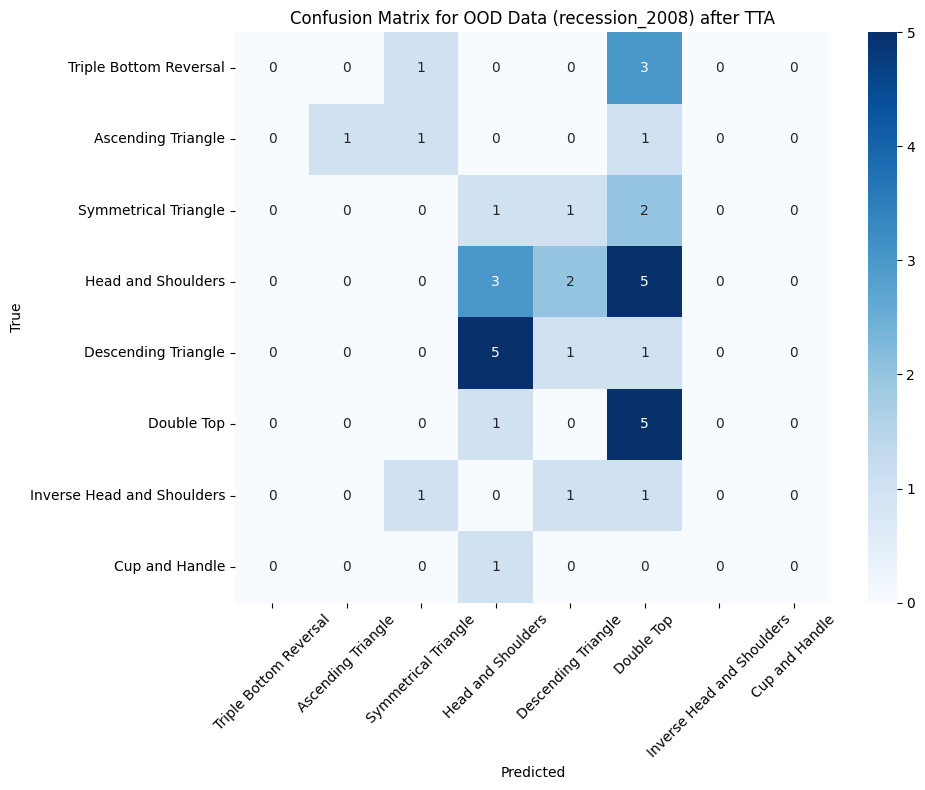

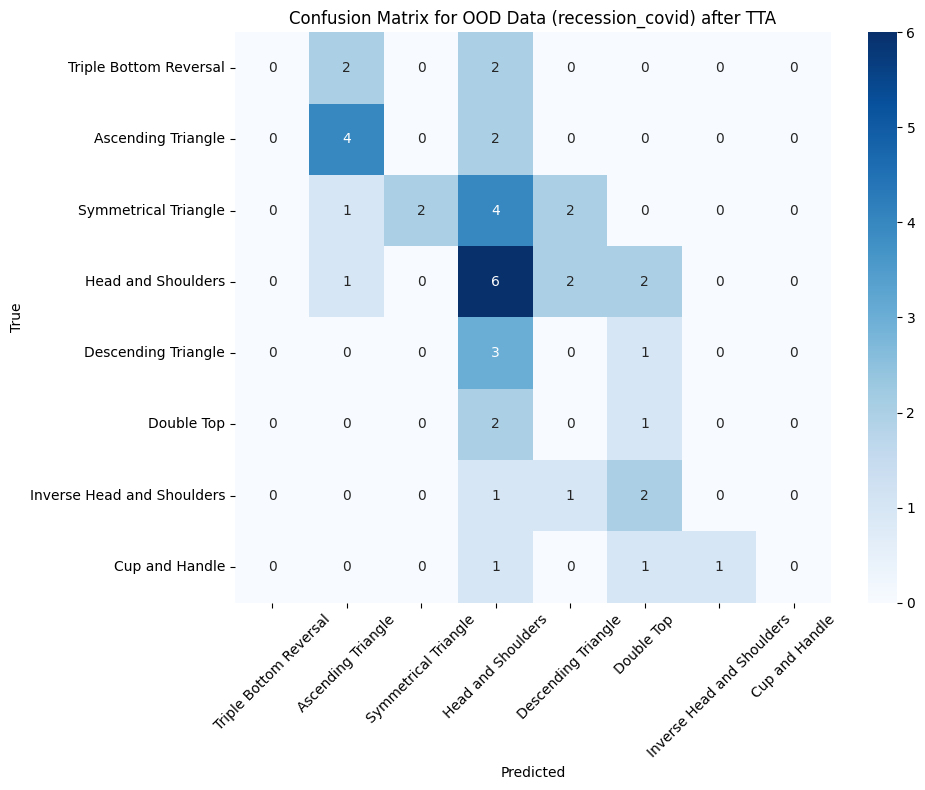

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import timm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
model = timm.create_model('crossvit_15_240', pretrained=False, num_classes=num_classes, drop_rate=0.3)
model_path = '/content/drive/MyDrive/dataset_yolo_final/crossvit_best_model.pth'
try:
    model.load_state_dict(torch.load(model_path))
    print(f"Successfully loaded pre-trained model from {model_path}")
except FileNotFoundError:
    raise FileNotFoundError(f"Model file not found at {model_path}. Please ensure the model was saved during training.")
model = model.to(device)

# Define the base transform (same as validation transform for consistency)
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define augmentation transforms for test-time augmentation
augmentations = [
    base_transform,  # Original image
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
]

# Diversity loss to prevent class collapse
def diversity_loss(probs):
    mean_probs = probs.mean(dim=0)  # Average probability per class across the batch
    uniform = torch.ones_like(mean_probs) / num_classes
    kl_div = F.kl_div(mean_probs.log(), uniform, reduction='batchmean')
    return kl_div

# Test-Time Adaptation function with Adjusted Pseudo-Labeling and More Augmentations
def test_time_adaptation(model, ood_loader, num_epochs=5, lr=1e-5, confidence_threshold=0.7, diversity_weight=0.1, save_path=None):
    # Step 1: Batch Normalization Adaptation
    print("Adapting batch normalization statistics...")
    model.train()  # Set to train mode to update BN statistics
    with torch.no_grad():
        for images, _ in ood_loader:
            images = images.to(device)
            _ = model(images)  # Forward pass to update BN statistics
    model.eval()

    # Evaluate after BN adaptation with test-time augmentation
    pre_tta_preds = []
    pre_tta_labels = []
    with torch.no_grad():
        for images, labels in ood_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Apply test-time augmentation
            all_outputs = []
            for aug in augmentations:
                aug_images = torch.stack([aug(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)
                outputs = model(aug_images)
                all_outputs.append(outputs)
            # Average predictions across augmentations
            outputs = torch.mean(torch.stack(all_outputs), dim=0)
            _, predicted = torch.max(outputs, 1)
            pre_tta_preds.extend(predicted.cpu().numpy())
            pre_tta_labels.extend(labels.cpu().numpy())
    pre_tta_acc = accuracy_score(pre_tta_labels, pre_tta_preds)
    print(f"Accuracy after BN adaptation and test-time augmentation: {pre_tta_acc:.4f}")

    #  Pseudo-Labeling with Confidence Threshold and Diversity Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Add weight decay for regularization
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        tta_loss = 0.0
        div_loss_total = 0.0
        total_samples = 0
        for images, _ in ood_loader:  # Ignore true labels during TTA
            images = images.to(device)
            batch_size = images.size(0)

            # Generate pseudo-labels
            with torch.no_grad():
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                # Select high-confidence predictions
                confident_mask = max_probs > confidence_threshold
                if not confident_mask.any():
                    continue  # Skip batch if no confident predictions

            # Fine-tune on confident pseudo-labels
            optimizer.zero_grad()
            outputs = model(images[confident_mask])
            pseudo_loss = criterion(outputs, pseudo_labels[confident_mask])

            # Compute diversity loss
            probs = F.softmax(outputs, dim=1)
            div_loss = diversity_loss(probs)

            # Combine losses
            loss = pseudo_loss + diversity_weight * div_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
            optimizer.step()
            tta_loss += pseudo_loss.item() * confident_mask.sum().item()
            div_loss_total += div_loss.item() * batch_size
            total_samples += confident_mask.sum().item()

        if total_samples > 0:
            tta_loss /= total_samples
            div_loss_total /= len(ood_loader.dataset)
            print(f"TTA Epoch {epoch+1}/{num_epochs}, Pseudo-Label Loss: {tta_loss:.4f}, Diversity Loss: {div_loss_total:.4f}, Samples Used: {total_samples}")
        else:
            print(f"TTA Epoch {epoch+1}/{num_epochs}, No confident predictions above threshold")

    # Evaluate after TTA with test-time augmentation
    model.eval()
    post_tta_preds = []
    post_tta_labels = []
    with torch.no_grad():
        for images, labels in ood_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Apply test-time augmentation
            all_outputs = []
            for aug in augmentations:
                aug_images = torch.stack([aug(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)
                outputs = model(aug_images)
                all_outputs.append(outputs)
            # Average predictions across augmentations
            outputs = torch.mean(torch.stack(all_outputs), dim=0)
            _, predicted = torch.max(outputs, 1)
            post_tta_preds.extend(predicted.cpu().numpy())
            post_tta_labels.extend(labels.cpu().numpy())
    post_tta_acc = accuracy_score(post_tta_labels, post_tta_preds)
    print(f"Accuracy after TTA: {post_tta_acc:.4f}")

    # Print per-class accuracy
    per_class_acc = {}
    for cls_id in range(num_classes):
        cls_mask = np.array(post_tta_labels) == cls_id
        if cls_mask.sum() > 0:
            cls_acc = accuracy_score(np.array(post_tta_labels)[cls_mask], np.array(post_tta_preds)[cls_mask])
            per_class_acc[id_to_class[cls_id]] = cls_acc
    print("Per-class accuracy after TTA:", per_class_acc)

    # Save the adapted model if a save path is provided
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Saved adapted model to {save_path}")

    # Split OOD data into recession_2008 and recession_covid for separate evaluation
    recession_2008_start = pd.to_datetime('2007-11-27')
    recession_2008_end = pd.to_datetime('2008-09-02')
    recession_covid_start = pd.to_datetime('2019-10-10')
    recession_covid_end = pd.to_datetime('2020-05-14')

    recession_2008_paths = []
    recession_2008_labels = []
    recession_covid_paths = []
    recession_covid_labels = []

    # Load OOD data to get dates
    ood_df = pd.read_csv(os.path.join(processed_data_dir, 'ood_data.csv'))
    ood_data = []
    for _, row in ood_df.iterrows():
        ood_data.append((
            row['Symbol_Period'],
            None,  # feats not needed
            row['Label'],
            pd.to_datetime(row['Start_Date']),
            pd.to_datetime(row['End_Date'])
        ))

    for img_path, label, (_, _, _, start_date, end_date) in zip(ood_image_paths, ood_labels, ood_data):
        if (start_date <= recession_2008_end) and (end_date >= recession_2008_start):
            recession_2008_paths.append(img_path)
            recession_2008_labels.append(label)
        elif (start_date <= recession_covid_end) and (end_date >= recession_covid_start):
            recession_covid_paths.append(img_path)
            recession_covid_labels.append(label)

    recession_2008_dataset = GAFDataset(recession_2008_paths, recession_2008_labels, transform=base_transform)
    recession_covid_dataset = GAFDataset(recession_covid_paths, recession_covid_labels, transform=base_transform)

    recession_2008_loader = DataLoader(recession_2008_dataset, batch_size=32, shuffle=False)
    recession_covid_loader = DataLoader(recession_covid_dataset, batch_size=32, shuffle=False)

    # Evaluate on recession_2008
    recession_2008_preds = []
    recession_2008_true = []
    with torch.no_grad():
        for images, labels in recession_2008_loader:
            images = images.to(device)
            labels = labels.to(device)
            all_outputs = []
            for aug in augmentations:
                aug_images = torch.stack([aug(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)
                outputs = model(aug_images)
                all_outputs.append(outputs)
            outputs = torch.mean(torch.stack(all_outputs), dim=0)
            preds = torch.argmax(outputs, dim=1)
            recession_2008_preds.extend(preds.cpu().numpy())
            recession_2008_true.extend(labels.cpu().numpy())

    recession_2008_accuracy = accuracy_score(recession_2008_true, recession_2008_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(recession_2008_true, recession_2008_preds, average='weighted', zero_division=0)
    print("\n--- OOD Evaluation Results (recession_2008) after TTA ---")
    print(f"OOD Accuracy: {recession_2008_accuracy:.4f}")
    print(f"OOD Precision: {precision:.4f}")
    print(f"OOD Recall: {recall:.4f}")
    print(f"OOD F1: {f1:.4f}")

    # Compute and plot confusion matrix for recession_2008
    cm_2008 = confusion_matrix(recession_2008_true, recession_2008_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_2008, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for OOD Data (recession_2008) after TTA')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{base_path}/confusion_matrix_recession_2008_tta.png')

    # Evaluate on recession_covid
    recession_covid_preds = []
    recession_covid_true = []
    with torch.no_grad():
        for images, labels in recession_covid_loader:
            images = images.to(device)
            labels = labels.to(device)
            all_outputs = []
            for aug in augmentations:
                aug_images = torch.stack([aug(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)
                outputs = model(aug_images)
                all_outputs.append(outputs)
            outputs = torch.mean(torch.stack(all_outputs), dim=0)
            preds = torch.argmax(outputs, dim=1)
            recession_covid_preds.extend(preds.cpu().numpy())
            recession_covid_true.extend(labels.cpu().numpy())

    recession_covid_accuracy = accuracy_score(recession_covid_true, recession_covid_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(recession_covid_true, recession_covid_preds, average='weighted', zero_division=0)
    print("\n--- OOD Evaluation Results (recession_covid) after TTA ---")
    print(f"OOD Accuracy: {recession_covid_accuracy:.4f}")
    print(f"OOD Precision: {precision:.4f}")
    print(f"OOD Recall: {recall:.4f}")
    print(f"OOD F1: {f1:.4f}")

    # Compute and plot confusion matrix for recession_covid
    cm_covid = confusion_matrix(recession_covid_true, recession_covid_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_covid, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for OOD Data (recession_covid) after TTA')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{base_path}/confusion_matrix_recession_covid_tta.png')

    # Combined OOD evaluation (for reference)
    ood_preds = recession_2008_preds + recession_covid_preds
    ood_true = recession_2008_true + recession_covid_true
    ood_accuracy = accuracy_score(ood_true, ood_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(ood_true, ood_preds, average='weighted', zero_division=0)
    print("\n--- Combined OOD Evaluation Results (recession_2008 and recession_covid) after TTA ---")
    print(f"OOD Accuracy: {ood_accuracy:.4f}")
    print(f"OOD Precision: {precision:.4f}")
    print(f"OOD Recall: {recall:.4f}")
    print(f"OOD F1: {f1:.4f}")

    return pre_tta_acc, post_tta_acc

# Run Test-Time Adaptation
save_path = '/content/drive/MyDrive/dataset_yolo_final/crossvit_tta_adapted_model.pth'
pre_tta_acc, post_tta_acc = test_time_adaptation(
    model, ood_loader, num_epochs=5, lr=1e-5, confidence_threshold=0.7, diversity_weight=0.1, save_path=save_path
)
print(f"Improvement from TTA: {(post_tta_acc - pre_tta_acc):.4f}")

## Hypertuning model-2


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/dataset_yolo_final'
processed_data_dir = f'{base_path}/processed_data'
images_base_dir = f'{base_path}/gaf_images'

# Define class mappings
class_to_id = {
    'Triple Bottom Reversal': 0,
    'Ascending Triangle': 1,
    'Symmetrical Triangle': 2,
    'Head and Shoulders': 3,
    'Descending Triangle': 4,
    'Double Top': 5,
    'Inverse Head and Shoulders': 6,
    'Cup and Handle': 7
}
id_to_class = {v: k for k, v in class_to_id.items()}
class_names = list(class_to_id.keys())
num_classes = len(class_names)

# Load preprocessed train and OOD data
train_data_path = os.path.join(processed_data_dir, 'train_data.csv')
ood_data_path = os.path.join(processed_data_dir, 'ood_data.csv')
train_df = pd.read_csv(train_data_path)
ood_df = pd.read_csv(ood_data_path)

# Load existing GAF image paths
train_images_dir = os.path.join(images_base_dir, 'train')
ood_images_dir = os.path.join(images_base_dir, 'ood')

train_image_paths = []
train_labels = []
for _, row in train_df.iterrows():
    symbol_period = row['Symbol_Period']
    label = class_to_id[row['Label']]
    img_name = symbol_period.replace('-', '_to_') + '_png.png'
    img_path = os.path.join(train_images_dir, img_name)
    train_image_paths.append(img_path)
    train_labels.append(label)

ood_image_paths = []
ood_labels = []
for _, row in ood_df.iterrows():
    symbol_period = row['Symbol_Period']
    label = class_to_id[row['Label']]
    img_name = symbol_period.replace('-', '_to_') + '_png.png'
    img_path = os.path.join(ood_images_dir, img_name)
    ood_image_paths.append(img_path)
    ood_labels.append(label)

#  Print class distribution
print("Training labels distribution:", Counter([id_to_class[label] for label in train_labels]))
print("OOD labels distribution:", Counter([id_to_class[label] for label in ood_labels]))

#  Print sample image-label pairs
print("Sample training image-label pairs:")
for img_path, label in zip(train_image_paths[:5], train_labels[:5]):
    print(f"Image: {img_path}, Label: {id_to_class[label]} ({label})")
print("Sample OOD image-label pairs:")
for img_path, label in zip(ood_image_paths[:5], ood_labels[:5]):
    print(f"Image: {img_path}, Label: {id_to_class[label]} ({label})")

# Define transforms with more aggressive augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05)  # Increased noise
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset for GAF Images
class GAFDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        # Resize to model input size
        image = image.resize((224, 224), Image.Resampling.LANCZOS)
        if self.transform:
            image = self.transform(image)
        return image, label

# Split training data into train and validation sets (80-20 split)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Create datasets
train_dataset = GAFDataset(train_paths, train_labels, transform=train_transform)
valid_dataset = GAFDataset(val_paths, val_labels, transform=valid_transform)
ood_dataset = GAFDataset(ood_image_paths, ood_labels, transform=valid_transform)

# Compute class distribution for weighted sampling
class_counts = Counter(train_labels)
print("Training class distribution:", class_counts)

# Adjusted weighted sampling
weights = 1.0 / torch.tensor([class_counts[i] for i in range(num_classes)], dtype=torch.float)
weights = weights ** 0.5  # Soften the weights
sample_weights = torch.tensor([weights[train_labels[i]] for i in range(len(train_labels))], dtype=torch.float)
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)
ood_loader = DataLoader(ood_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(valid_dataset)}, OOD samples: {len(ood_dataset)}")

# Compute class weights for Focal Loss (alpha)
total_samples = sum(class_counts.values())
alpha_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
alpha_weights = torch.tensor(alpha_weights, dtype=torch.float32)
print("Alpha weights for Focal Loss:", alpha_weights)

Mounted at /content/drive
Training labels distribution: Counter({'Cup and Handle': 96, 'Triple Bottom Reversal': 92, 'Inverse Head and Shoulders': 92, 'Double Top': 91, 'Ascending Triangle': 91, 'Descending Triangle': 89, 'Symmetrical Triangle': 87, 'Head and Shoulders': 79})
OOD labels distribution: Counter({'Head and Shoulders': 21, 'Symmetrical Triangle': 13, 'Descending Triangle': 11, 'Double Top': 9, 'Ascending Triangle': 9, 'Triple Bottom Reversal': 8, 'Inverse Head and Shoulders': 7, 'Cup and Handle': 4})
Sample training image-label pairs:
Image: /content/drive/MyDrive/dataset_yolo_final/gaf_images/train/EICHERMOT_1711_to_1800_png.png, Label: Double Top (5)
Image: /content/drive/MyDrive/dataset_yolo_final/gaf_images/train/ADANIPORTS_811_to_900_synthetic_58_png.png, Label: Cup and Handle (7)
Image: /content/drive/MyDrive/dataset_yolo_final/gaf_images/train/SUNPHARMA_3511_to_3600_png.png, Label: Double Top (5)
Image: /content/drive/MyDrive/dataset_yolo_final/gaf_images/train/JSWST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Use a smaller CrossViT model to reduce overfitting
model = timm.create_model('crossvit_9_240', pretrained=True, num_classes=num_classes, drop_rate=0.5)  # Increased dropout
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model loaded on:", device)

# Define Focal Loss with class-weighted alpha
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[target]
            focal_loss = alpha_t * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Training and evaluation function
def train_and_evaluate(model, train_loader, valid_loader, num_epochs=100, lr=5e-5):  # Lowered learning rate
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-3)  # Increased weight decay
    criterion = FocalLoss(alpha=alpha_weights.to(device), gamma=2.0).to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    # Freeze backbone initially
    for param in model.parameters():
        param.requires_grad = False
    for param in model.head.parameters():
        param.requires_grad = True

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

    for epoch in range(num_epochs):
        if epoch == 10:
            for param in model.parameters():
                param.requires_grad = True
            print("Unfreezing all layers")
            optimizer.param_groups[0]['lr'] = 7.5e-5  # Slightly increased lr after unfreezing

        # Training
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        val_loss /= len(valid_loader.dataset)
        val_acc = correct_val / total_val
        precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='weighted', zero_division=0)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1: {f1:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/dataset_yolo_final/crossvit_best_model-2.pth')
            print(f"Saved best model with Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return history

# Train and Evaluate
history = train_and_evaluate(model, train_loader, valid_loader, num_epochs=100)

Model loaded on: cuda
Epoch 1/100, Train Loss: 1.5956, Train Acc: 0.1431, Val Loss: 1.6078, Val Acc: 0.1111, Val Precision: 0.0123, Val Recall: 0.1111, Val F1: 0.0222, LR: 0.000050
Saved best model with Val Loss: 1.6078
Epoch 2/100, Train Loss: 1.6119, Train Acc: 0.1152, Val Loss: 1.6054, Val Acc: 0.1111, Val Precision: 0.0132, Val Recall: 0.1111, Val F1: 0.0235, LR: 0.000050
Saved best model with Val Loss: 1.6054
Epoch 3/100, Train Loss: 1.6139, Train Acc: 0.1099, Val Loss: 1.6031, Val Acc: 0.1250, Val Precision: 0.0487, Val Recall: 0.1250, Val F1: 0.0445, LR: 0.000050
Saved best model with Val Loss: 1.6031
Epoch 4/100, Train Loss: 1.5978, Train Acc: 0.1274, Val Loss: 1.6007, Val Acc: 0.1458, Val Precision: 0.0807, Val Recall: 0.1458, Val F1: 0.0759, LR: 0.000050
Saved best model with Val Loss: 1.6007
Epoch 5/100, Train Loss: 1.5941, Train Acc: 0.1326, Val Loss: 1.5985, Val Acc: 0.1319, Val Precision: 0.0605, Val Recall: 0.1319, Val F1: 0.0630, LR: 0.000050
Saved best model with Val L

Successfully loaded pre-trained model from /content/drive/MyDrive/dataset_yolo_final/crossvit_best_model-2.pth
OOD class distribution before oversampling: Counter({3: 21, 2: 13, 4: 11, 5: 9, 1: 9, 0: 8, 6: 7, 7: 4})
OOD class distribution after oversampling: Counter({3: 21, 6: 21, 7: 20, 1: 18, 5: 18, 0: 16, 2: 13, 4: 11})
Adapting batch normalization statistics...
Accuracy after BN adaptation and test-time augmentation: 0.1951
TTA Epoch 1/5, Pseudo-Label Loss: 0.8386, Diversity Loss: 0.0417, Entropy Loss: 1.7017, Samples Used: 39
TTA Epoch 2/5, Pseudo-Label Loss: 0.7756, Diversity Loss: 0.0500, Entropy Loss: 1.6146, Samples Used: 67
TTA Epoch 3/5, Pseudo-Label Loss: 0.6725, Diversity Loss: 0.0594, Entropy Loss: 1.5212, Samples Used: 77
TTA Epoch 4/5, Pseudo-Label Loss: 0.6119, Diversity Loss: 0.0654, Entropy Loss: 1.4795, Samples Used: 89
TTA Epoch 5/5, Pseudo-Label Loss: 0.5709, Diversity Loss: 0.0708, Entropy Loss: 1.3741, Samples Used: 109
post_tta_preds sample: [np.int64(1), np.in

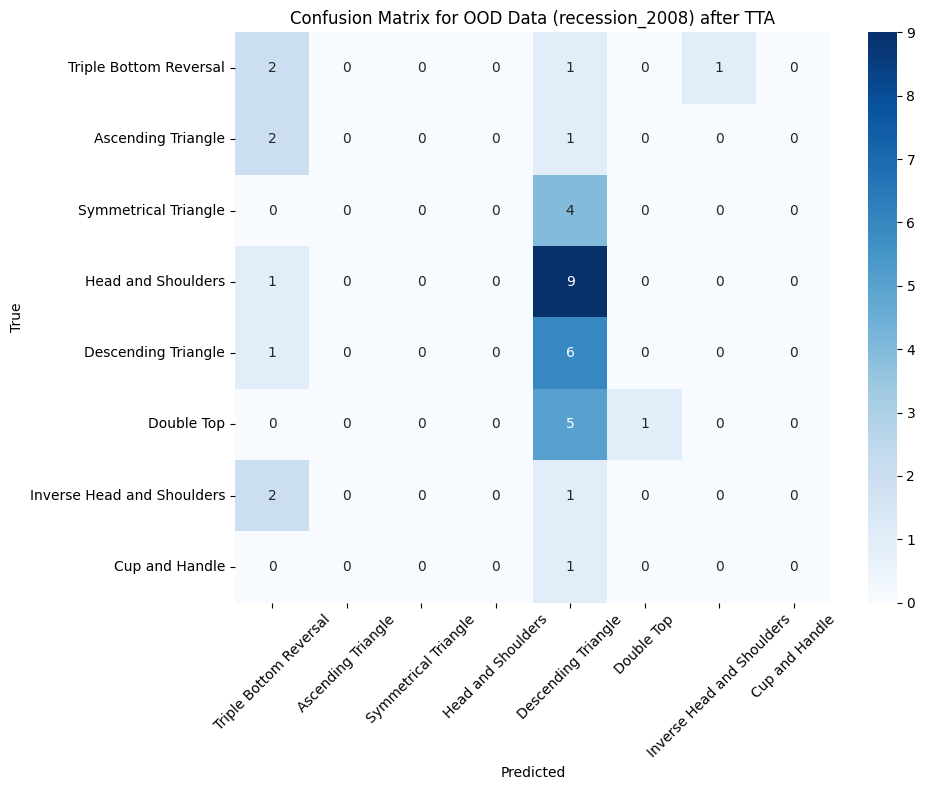

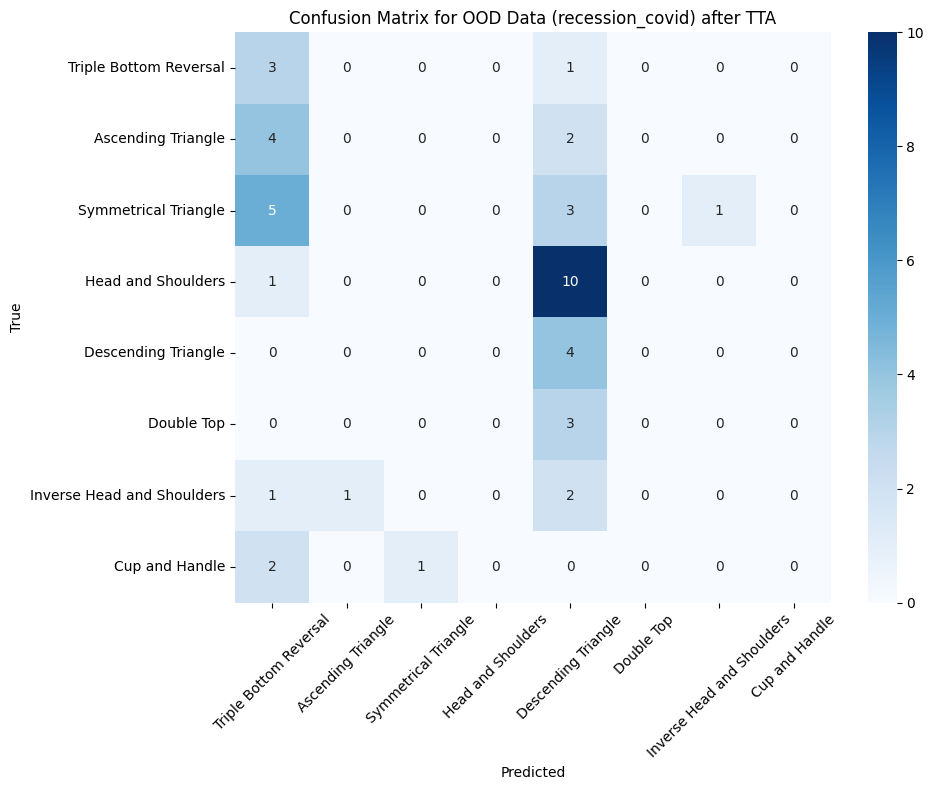

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import timm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model (same as training)
model = timm.create_model('crossvit_9_240', pretrained=False, num_classes=num_classes, drop_rate=0.5)
model_path = '/content/drive/MyDrive/dataset_yolo_final/crossvit_best_model-2.pth'
try:
    model.load_state_dict(torch.load(model_path))
    print(f"Successfully loaded pre-trained model from {model_path}")
except FileNotFoundError:
    raise FileNotFoundError(f"Model file not found at {model_path}. Please ensure the model was saved during training.")
model = model.to(device)

# Define the base transform (same as validation transform for consistency)
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define augmentation transforms for test-time augmentation (diverse augmentations)
augmentations = [
    base_transform,  # Original image
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    transforms.Compose([
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
]

# Oversample minority classes in OOD data
ood_class_counts = Counter(ood_labels)
print("OOD class distribution before oversampling:", ood_class_counts)
target_ood_samples = max(ood_class_counts.values())  # Match the most frequent class
oversampled_ood_image_paths = []
oversampled_ood_labels = []
for cls_id in range(num_classes):
    cls_indices = [i for i, label in enumerate(ood_labels) if label == cls_id]
    cls_count = len(cls_indices)
    if cls_count == 0:
        continue
    oversample_factor = max(1, target_ood_samples // cls_count)
    for _ in range(oversample_factor):
        for idx in cls_indices:
            oversampled_ood_image_paths.append(ood_image_paths[idx])
            oversampled_ood_labels.append(ood_labels[idx])

# Create oversampled OOD dataset
oversampled_ood_dataset = GAFDataset(oversampled_ood_image_paths, oversampled_ood_labels, transform=base_transform)
oversampled_ood_loader = DataLoader(oversampled_ood_dataset, batch_size=32, shuffle=False)
print("OOD class distribution after oversampling:", Counter(oversampled_ood_labels))

# Diversity loss to prevent class collapse
def diversity_loss(probs):
    mean_probs = probs.mean(dim=0)  # Average probability per class across the batch
    uniform = torch.ones_like(mean_probs) / num_classes
    kl_div = F.kl_div(mean_probs.log(), uniform, reduction='batchmean')
    return kl_div

# Entropy minimization loss
def entropy_loss(probs):
    entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
    return entropy.mean()

# Test-Time Adaptation function with lowered confidence threshold
def test_time_adaptation(model, ood_loader, oversampled_ood_loader, num_epochs=5, lr=1e-5, confidence_threshold=0.4, diversity_weight=0.1, entropy_weight=0.1, save_path=None):
    # Step 1: Batch Normalization Adaptation
    print("Adapting batch normalization statistics...")
    model.train()  # Set to train mode to update BN statistics
    with torch.no_grad():
        for images, _ in oversampled_ood_loader:
            images = images.to(device)
            _ = model(images)  # Forward pass to update BN statistics
    model.eval()

    # Evaluate after BN adaptation with test-time augmentation
    pre_tta_preds = []
    pre_tta_labels = []
    with torch.no_grad():
        for images, labels in ood_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Apply test-time augmentation
            all_outputs = []
            for aug in augmentations:
                aug_images = torch.stack([aug(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)
                outputs = model(aug_images)
                all_outputs.append(outputs)
            # Average predictions across augmentations
            outputs = torch.mean(torch.stack(all_outputs), dim=0)
            _, predicted = torch.max(outputs, 1)
            pre_tta_preds.extend(predicted.cpu().numpy())
            pre_tta_labels.extend(labels.cpu().numpy())
    pre_tta_acc = accuracy_score(pre_tta_labels, pre_tta_preds)
    print(f"Accuracy after BN adaptation and test-time augmentation: {pre_tta_acc:.4f}")

    #  Pseudo-Labeling with Confidence Threshold, Diversity Loss, and Entropy Minimization
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        tta_loss = 0.0
        div_loss_total = 0.0
        ent_loss_total = 0.0
        total_samples = 0
        for images, _ in oversampled_ood_loader:
            images = images.to(device)
            batch_size = images.size(0)

            # Generate pseudo-labels
            with torch.no_grad():
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                # Select high-confidence predictions with lowered threshold
                confident_mask = max_probs > confidence_threshold
                if not confident_mask.any():
                    continue

            # Fine-tune on confident pseudo-labels
            optimizer.zero_grad()
            outputs = model(images[confident_mask])
            pseudo_loss = criterion(outputs, pseudo_labels[confident_mask])

            # Compute diversity loss
            probs = F.softmax(outputs, dim=1)
            div_loss = diversity_loss(probs)

            # Compute entropy loss on all samples
            all_outputs = model(images)
            all_probs = F.softmax(all_outputs, dim=1)
            ent_loss = entropy_loss(all_probs)

            # Combine losses
            loss = pseudo_loss + diversity_weight * div_loss + entropy_weight * ent_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            tta_loss += pseudo_loss.item() * confident_mask.sum().item()
            div_loss_total += div_loss.item() * batch_size
            ent_loss_total += ent_loss.item() * batch_size
            total_samples += confident_mask.sum().item()

        if total_samples > 0:
            tta_loss /= total_samples
            div_loss_total /= len(oversampled_ood_loader.dataset)
            ent_loss_total /= len(oversampled_ood_loader.dataset)
            print(f"TTA Epoch {epoch+1}/{num_epochs}, Pseudo-Label Loss: {tta_loss:.4f}, Diversity Loss: {div_loss_total:.4f}, Entropy Loss: {ent_loss_total:.4f}, Samples Used: {total_samples}")
        else:
            print(f"TTA Epoch {epoch+1}/{num_epochs}, No confident predictions above threshold")

    # Evaluate after TTA with test-time augmentation (on original OOD loader)
    model.eval()
    post_tta_preds = []
    post_tta_labels = []
    with torch.no_grad():
        for images, labels in ood_loader:
            images = images.to(device)
            labels = labels.to(device)
            all_outputs = []
            for aug in augmentations:
                aug_images = torch.stack([aug(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)
                outputs = model(aug_images)
                all_outputs.append(outputs)
            outputs = torch.mean(torch.stack(all_outputs), dim=0)
            _, predicted = torch.max(outputs, 1)
            post_tta_preds.extend(predicted.cpu().numpy())
            post_tta_labels.extend(labels.cpu().numpy())
    print("post_tta_preds sample:", post_tta_preds[:5], "type:", type(post_tta_preds[0]))
    print("post_tta_labels sample:", post_tta_labels[:5], "type:", type(post_tta_labels[0]))
    post_tta_acc = accuracy_score(post_tta_labels, post_tta_preds)
    print(f"Accuracy after TTA: {post_tta_acc:.4f}")

    # Print per-class accuracy
    per_class_acc = {}
    for cls_id in range(num_classes):
        cls_mask = np.array(post_tta_labels) == cls_id
        if cls_mask.sum() > 0:
            cls_acc = accuracy_score(np.array(post_tta_labels)[cls_mask], np.array(post_tta_preds)[cls_mask])
            per_class_acc[id_to_class[cls_id]] = cls_acc
    print("Per-class accuracy after TTA:", per_class_acc)

    # Save the adapted model if a save path is provided
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Saved adapted model to {save_path}")

    # Split OOD data into recession_2008 and recession_covid for separate evaluation
    recession_2008_start = pd.to_datetime('2007-11-27')
    recession_2008_end = pd.to_datetime('2008-09-02')
    recession_covid_start = pd.to_datetime('2019-10-10')
    recession_covid_end = pd.to_datetime('2020-05-14')

    recession_2008_paths = []
    recession_2008_labels = []
    recession_covid_paths = []
    recession_covid_labels = []

    # Load OOD data to get dates
    ood_df = pd.read_csv(os.path.join(processed_data_dir, 'ood_data.csv'))
    ood_data = []
    for _, row in ood_df.iterrows():
        ood_data.append((
            row['Symbol_Period'],
            None,  # feats not needed
            row['Label'],
            pd.to_datetime(row['Start_Date']),
            pd.to_datetime(row['End_Date'])
        ))

    for img_path, label, (_, _, _, start_date, end_date) in zip(ood_image_paths, ood_labels, ood_data):
        if (start_date <= recession_2008_end) and (end_date >= recession_2008_start):
            recession_2008_paths.append(img_path)
            recession_2008_labels.append(label)
        elif (start_date <= recession_covid_end) and (end_date >= recession_covid_start):
            recession_covid_paths.append(img_path)
            recession_covid_labels.append(label)

    recession_2008_dataset = GAFDataset(recession_2008_paths, recession_2008_labels, transform=base_transform)
    recession_covid_dataset = GAFDataset(recession_covid_paths, recession_covid_labels, transform=base_transform)

    recession_2008_loader = DataLoader(recession_2008_dataset, batch_size=32, shuffle=False)
    recession_covid_loader = DataLoader(recession_covid_dataset, batch_size=32, shuffle=False)

    # Evaluate on recession_2008
    recession_2008_preds = []
    recession_2008_true = []
    with torch.no_grad():
        for images, labels in recession_2008_loader:
            images = images.to(device)
            labels = labels.to(device)
            all_outputs = []
            for aug in augmentations:
                aug_images = torch.stack([aug(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)
                outputs = model(aug_images)
                all_outputs.append(outputs)
            outputs = torch.mean(torch.stack(all_outputs), dim=0)
            preds = torch.argmax(outputs, dim=1)
            recession_2008_preds.extend(preds.cpu().numpy())
            recession_2008_true.extend(labels.cpu().numpy())

    recession_2008_accuracy = accuracy_score(recession_2008_true, recession_2008_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(recession_2008_true, recession_2008_preds, average='weighted', zero_division=0)
    print("\n--- OOD Evaluation Results (recession_2008) after TTA ---")
    print(f"OOD Accuracy: {recession_2008_accuracy:.4f}")
    print(f"OOD Precision: {precision:.4f}")
    print(f"OOD Recall: {recall:.4f}")
    print(f"OOD F1: {f1:.4f}")

    # Compute and plot confusion matrix for recession_2008
    cm_2008 = confusion_matrix(recession_2008_true, recession_2008_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_2008, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for OOD Data (recession_2008) after TTA')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{base_path}/confusion_matrix_recession_2008_tta.png')

    # Evaluate on recession_covid
    recession_covid_preds = []
    recession_covid_true = []
    with torch.no_grad():
        for images, labels in recession_covid_loader:
            images = images.to(device)
            labels = labels.to(device)
            all_outputs = []
            for aug in augmentations:
                aug_images = torch.stack([aug(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)
                outputs = model(aug_images)
                all_outputs.append(outputs)
            outputs = torch.mean(torch.stack(all_outputs), dim=0)
            preds = torch.argmax(outputs, dim=1)
            recession_covid_preds.extend(preds.cpu().numpy())
            recession_covid_true.extend(labels.cpu().numpy())

    recession_covid_accuracy = accuracy_score(recession_covid_true, recession_covid_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(recession_covid_true, recession_covid_preds, average='weighted', zero_division=0)
    print("\n--- OOD Evaluation Results (recession_covid) after TTA ---")
    print(f"OOD Accuracy: {recession_covid_accuracy:.4f}")
    print(f"OOD Precision: {precision:.4f}")
    print(f"OOD Recall: {recall:.4f}")
    print(f"OOD F1: {f1:.4f}")

    # Compute and plot confusion matrix for recession_covid
    cm_covid = confusion_matrix(recession_covid_true, recession_covid_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_covid, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for OOD Data (recession_covid) after TTA')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{base_path}/confusion_matrix_recession_covid_tta.png')

    # Combined OOD evaluation (for reference)
    ood_preds = recession_2008_preds + recession_covid_preds
    ood_true = recession_2008_true + recession_covid_true
    ood_accuracy = accuracy_score(ood_true, ood_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(ood_true, ood_preds, average='weighted', zero_division=0)
    print("\n--- Combined OOD Evaluation Results (recession_2008 and recession_covid) after TTA ---")
    print(f"OOD Accuracy: {ood_accuracy:.4f}")
    print(f"OOD Precision: {precision:.4f}")
    print(f"OOD Recall: {recall:.4f}")
    print(f"OOD F1: {f1:.4f}")

    return pre_tta_acc, post_tta_acc

# Run Test-Time Adaptation with lowered confidence threshold
save_path = '/content/drive/MyDrive/dataset_yolo_final/crossvit_tta_adapted_model_low_conf.pth'
pre_tta_acc, post_tta_acc = test_time_adaptation(
    model, ood_loader, oversampled_ood_loader, num_epochs=5, lr=1e-5,
    confidence_threshold=0.4, diversity_weight=0.1, entropy_weight=0.1, save_path=save_path
)
print(f"Improvement from TTA: {(post_tta_acc - pre_tta_acc):.4f}")